# Modelo de deteccion de phishing en mensajes de texto  

Referencias:  
Abdullah, N., (2024). Phishing Email Dataset. https://www.kaggle.com/datasets/naserabdullahalam/phishing-email-dataset/data?select=phishing_email.csv



#### Analisis Exploratorio

In [1]:
import pandas as pd
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import nltk
import re
import unicodedata
import contractions
import textsearch
import matplotlib
import pylab as plt
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [37]:
df = pd.read_csv("datasets/Messages/phishing_email.csv")
df.head(10)

,text_combined,label
0,hpl nom may 25 2001 see attached file hplno 52...,0
1,nom actual vols 24 th forwarded sabrae zajac h...,0
2,enron actuals march 30 april 1 201 estimated a...,0
3,hpl nom may 30 2001 see attached file hplno 53...,0
4,hpl nom june 1 2001 see attached file hplno 60...,0
5,hpl nom may 31 2001 see attached file hplno 53...,0
6,9760 tried get fancy address came back forward...,0
7,hpl noms february 15 2000 see attached file hp...,0
8,fw pooling contract template original message ...,0
9,hpl nom march 28 2000 see attached file hplo 3...,0


In [38]:
df.info()
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82486 entries, 0 to 82485
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text_combined  82486 non-null  object
 1   label          82486 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.3+ MB
(82486, 2)


In [39]:
print("Good emails")
df[df.label == 0].sample(5)

Good emails


,text_combined,label
73293,yyyyspamassassintaintorg justin mason malte st...,0
25949,panda update spoke jim adams panda p new guy s...,0
67144,wray buntine wuotkbshiitfi please consider fol...,0
35356,steve hay rybvejulplanitcom craig berry wrote ...,0
68109,chris hoogendyk qmvwjastdbioumassedu marc perk...,0


In [40]:
print("Bad emails")
df[df.label == 1].sample(5)

Bad emails


,text_combined,label
36459,gregg conner akstcallkeymnsdgsallkeycom perfec...,1
37159,billie alford deviceeuut675webtvnet dear 197b7...,1
23675,perfect logo charset koi 8 r thinking breathin...,1
77252,pale moon your_friendindiansorg dear friend se...,1
81937,postmaster pmm_postmaster_00t6a0jjyuikpedugy6y...,1


In [41]:
df.isnull().sum()

text_combined    0
label            0
dtype: int64

<AxesSubplot: xlabel='label', ylabel='count'>

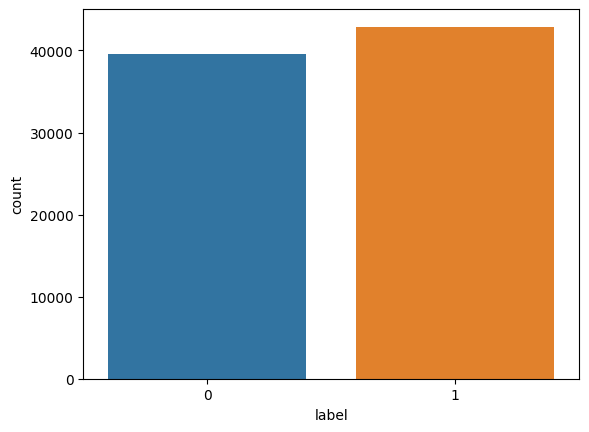

In [42]:
sns.countplot(x='label', data=df)

#### Tokenizacion

In [43]:
# Hacer minusculas los mensajes
df['text_combined'] = df['text_combined'].str.lower()

In [44]:
# Remove accents
def remove_accents(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

df['text_combined'] = df['text_combined'].apply(remove_accents)

df

,text_combined,label
0,hpl nom may 25 2001 see attached file hplno 52...,0
1,nom actual vols 24 th forwarded sabrae zajac h...,0
2,enron actuals march 30 april 1 201 estimated a...,0
3,hpl nom may 30 2001 see attached file hplno 53...,0
4,hpl nom june 1 2001 see attached file hplno 60...,0
...,...,...
82481,info advantageapartmentscom infoadvantageapart...,1
82482,monkeyorg helpdeskmonkeyorg monkeyorg hi josep...,1
82483,help center infohelpcentercoza_infohelpcenterc...,1
82484,metamask infosofamekarcom verify metamask wall...,1


In [45]:
# Remove special characters
def remove_special_characters(text):
    text = re.sub(r'[^a-zA-z\s]', '', text)
    return text

df['text_combined'] = df['text_combined'].apply(remove_special_characters)
df

,text_combined,label
0,hpl nom may see attached file hplno xls hpl...,0
1,nom actual vols th forwarded sabrae zajac hou...,0
2,enron actuals march april estimated actuals...,0
3,hpl nom may see attached file hplno xls hpl...,0
4,hpl nom june see attached file hplno xls hp...,0
...,...,...
82481,info advantageapartmentscom infoadvantageapart...,1
82482,monkeyorg helpdeskmonkeyorg monkeyorg hi josep...,1
82483,help center infohelpcentercoza_infohelpcenterc...,1
82484,metamask infosofamekarcom verify metamask wall...,1


In [46]:
# Correct contractions
def correct_contractions(text):
    return contractions.fix(text)

df['text_combined'] = df['text_combined'].apply(correct_contractions)
df

,text_combined,label
0,hpl nom may see attached file hplno xls hpl...,0
1,nom actual vols th forwarded sabrae zajac hou...,0
2,enron actuals march april estimated actuals...,0
3,hpl nom may see attached file hplno xls hpl...,0
4,hpl nom june see attached file hplno xls hp...,0
...,...,...
82481,info advantageapartmentscom infoadvantageapart...,1
82482,monkeyorg helpdeskmonkeyorg monkeyorg hi josep...,1
82483,help center infohelpcentercoza_infohelpcenterc...,1
82484,metamask infosofamekarcom verify metamask wall...,1


In [47]:
nltk.download('punkt')
df['text_combined'] = df.apply(lambda row: nltk.word_tokenize(row['text_combined']), axis=1)
df

[nltk_data] Downloading package punkt to C:\Users\Andrès
[nltk_data]     DLR\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,text_combined,label
0,"[hpl, nom, may, see, attached, file, hplno, xl...",0
1,"[nom, actual, vols, th, forwarded, sabrae, zaj...",0
2,"[enron, actuals, march, april, estimated, actu...",0
3,"[hpl, nom, may, see, attached, file, hplno, xl...",0
4,"[hpl, nom, june, see, attached, file, hplno, x...",0
...,...,...
82481,"[info, advantageapartmentscom, infoadvantageap...",1
82482,"[monkeyorg, helpdeskmonkeyorg, monkeyorg, hi, ...",1
82483,"[help, center, infohelpcentercoza_infohelpcent...",1
82484,"[metamask, infosofamekarcom, verify, metamask,...",1


In [48]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

def remove_stopwords(text):
    return [word for word in text if word not in stopwords]

df['text_combined'] = df['text_combined'].apply(remove_stopwords)
df

[nltk_data] Downloading package stopwords to C:\Users\Andrès
[nltk_data]     DLR\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text_combined,label
0,"[hpl, nom, may, see, attached, file, hplno, xl...",0
1,"[nom, actual, vols, th, forwarded, sabrae, zaj...",0
2,"[enron, actuals, march, april, estimated, actu...",0
3,"[hpl, nom, may, see, attached, file, hplno, xl...",0
4,"[hpl, nom, june, see, attached, file, hplno, x...",0
...,...,...
82481,"[info, advantageapartmentscom, infoadvantageap...",1
82482,"[monkeyorg, helpdeskmonkeyorg, monkeyorg, hi, ...",1
82483,"[help, center, infohelpcentercoza_infohelpcent...",1
82484,"[metamask, infosofamekarcom, verify, metamask,...",1


In [49]:
ps = PorterStemmer()

def stemming(text):
    return [ps.stem(word) for word in text]

df['text_combined'] = df['text_combined'].apply(stemming)


In [50]:
# Lemmatization
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

def lemmatization(text):
    return [wnl.lemmatize(word) for word in text]

df['text_combined'] = df['text_combined'].apply(lemmatization)
df

,text_combined,label
0,"[hpl, nom, may, see, attach, file, hplno, xl, ...",0
1,"[nom, actual, vol, th, forward, sabra, zajac, ...",0
2,"[enron, actual, march, april, estim, actual, m...",0
3,"[hpl, nom, may, see, attach, file, hplno, xl, ...",0
4,"[hpl, nom, june, see, attach, file, hplno, xl,...",0
...,...,...
82481,"[info, advantageapartmentscom, infoadvantageap...",1
82482,"[monkeyorg, helpdeskmonkeyorg, monkeyorg, hi, ...",1
82483,"[help, center, infohelpcentercoza_infohelpcent...",1
82484,"[metamask, infosofamekarcom, verifi, metamask,...",1


In [52]:
# Remove words with length less than 4 characters
def remove_short_words(text):
    return [word for word in text if len(word) > 3]

df['text_combined'] = df['text_combined'].apply(remove_short_words)

In [53]:
# Normalize text
def normalize_text(text):
    return ' '.join(text)

df['text_combined'] = df['text_combined'].apply(normalize_text)
df

,text_combined,label
0,attach file hplno hplno,0
1,actual forward sabra zajac enron capit trade r...,0
2,enron actual march april estim actual march fl...,0
3,attach file hplno hplno,0
4,june attach file hplno hplno,0
...,...,...
82481,info advantageapartmentscom infoadvantageapart...,1
82482,monkeyorg helpdeskmonkeyorg monkeyorg josepass...,1
82483,help center infohelpcentercoza_infohelpcenterc...,1
82484,metamask infosofamekarcom verifi metamask wall...,1


In [54]:
import string 

def text_preprocessing(text):
    text = str(text)
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('@\w+\s*', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('http', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]', '', text)
    return text

df['text_combined'] = df['text_combined'].apply(text_preprocessing)
df

,text_combined,label
0,attach file hplno hplno,0
1,actual forward sabra zajac enron capit trade r...,0
2,enron actual march april estim actual march fl...,0
3,attach file hplno hplno,0
4,june attach file hplno hplno,0
...,...,...
82481,info advantageapartmentscom infoadvantageapart...,1
82482,monkeyorg helpdeskmonkeyorg monkeyorg josepass...,1
82483,help center infohelpcentercozainfohelpcenterco...,1
82484,metamask infosofamekarcom verifi metamask wall...,1


In [63]:
# Remove specific words
def remove_specific_words(text):
    specific_words = ['subject', 'submiss', 'note', 'viru', 'virutotal', 
                      'submissionid', 'email', 'messag', 'file', 'enron', 
                      'mail', 'sender', 'receiv', 'attach', 'receiv', 'total']

    return ' '.join([word for word in text.split() if word not in specific_words])

df['text_combined'] = df['text_combined'].apply(remove_specific_words)

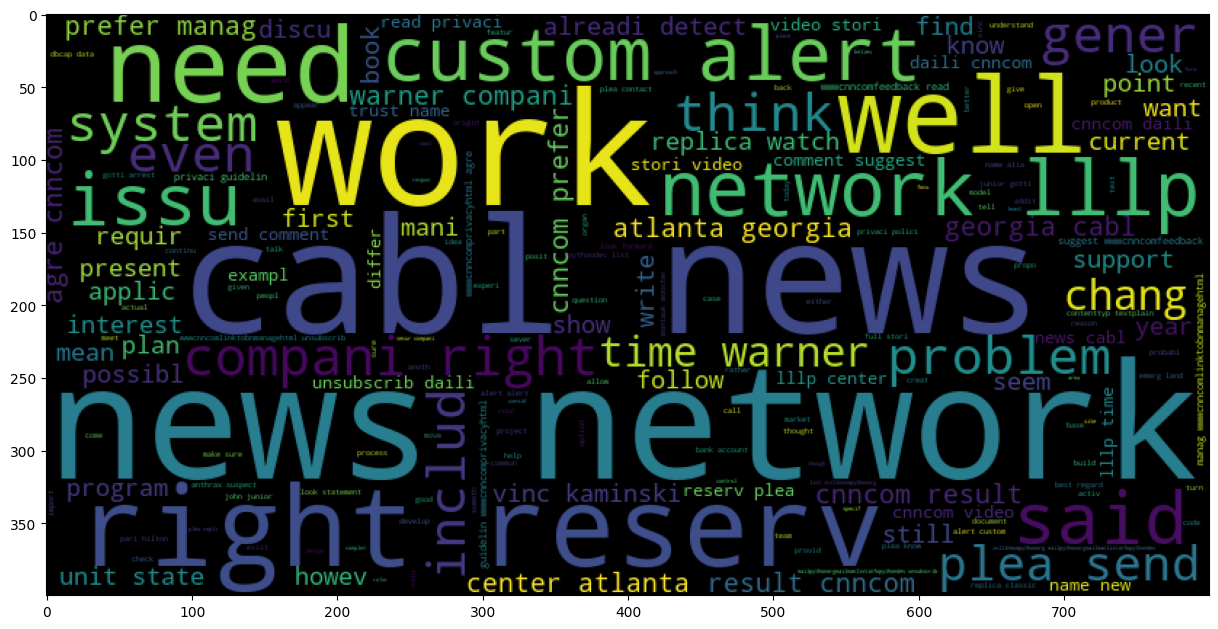

In [64]:
cloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110).generate(' '.join(df['text_combined']))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)

In [66]:
data = df.sample(frac=1).reset_index(drop=True)
data

,text_combined,label
0,gayelord hutton harrijokelatelestefi kclmbejcs...,1
1,patti crocker pattygxisd advanc formula keep s...,1
2,susan shabangu sussyshabcom dear sirma request...,1
3,lncreas spurm volum orgzm durat main benifit l...,1
4,colm maccarthaigh tasfstdlibnet louis ferguson...,0
...,...,...
82481,latest revis vinc made bold face edit document...,0
82482,explor super viagrka circumscrib nummul multis...,1
82483,arther olivia xfgkdjvgcgmmcjpcom ysrsqjf salma...,1
82484,samantha teinkemperabenaquicarrierscom take op...,1


In [73]:
# Nan values
data.isnull().sum()

data = data.dropna()

In [74]:
# Save data
data.to_csv('datasets/Messages/phishing_email_clean.csv', index=False)

#### Modelo TF-IDF

In [2]:
data = pd.read_csv('datasets/Messages/phishing_email_clean.csv')

tv = TfidfVectorizer(max_features=8000, ngram_range=(1, 3))
tv_matrix = tv.fit_transform(data['text_combined'])
tv_matrix = tv_matrix.toarray()

vocab = tv.get_feature_names_out()
tfIDF_df = pd.DataFrame(np.round(tv_matrix, 2), columns=vocab)
tfIDF_df

,aaai,aaron,aaron kulki,abacha,abandon,abidjan,abidjan cote,abil,abort,abraham,...,zero,zhang,zimbabw,zimin,zone,zonk,zurich,zvlllneumpythonorg,zvlllneumpythonorg mailpythonorgmailmanlistinfopythondev,zvlllneumpythonorg mailpythonorgmailmanlistinfopythondev unsubscrib
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82473,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot: >

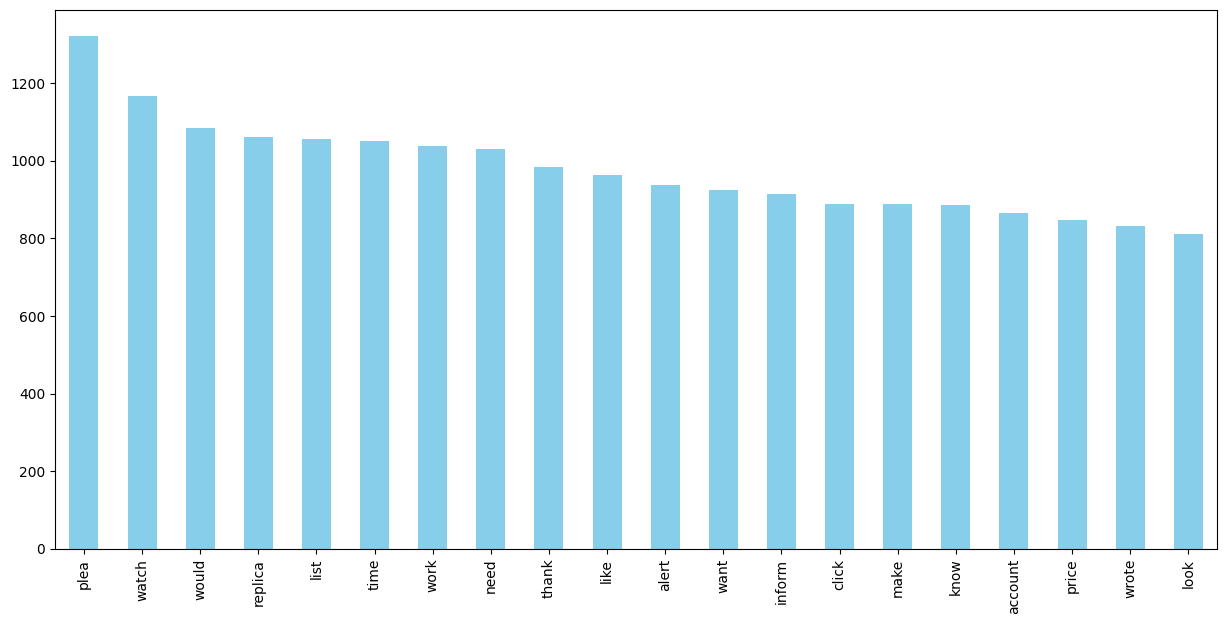

In [3]:
# Frequency of words
word_freq = tfIDF_df.sum()
word_freq = word_freq.sort_values(ascending=False)

word_freq[:20].plot(kind='bar', figsize=(15, 7), color='skyblue')

In [4]:
word_freq[:30]

plea       1322.21
watch      1167.52
would      1083.55
replica    1059.87
list       1056.08
time       1050.63
work       1037.66
need       1031.14
thank       984.62
like        963.62
alert       937.33
want        925.54
inform      913.10
click       887.40
make        887.15
know        885.06
account     864.04
price       846.88
wrote       830.84
look        811.64
help        804.39
best        783.19
compani     780.58
free        771.07
custom      756.94
money       755.79
name        739.32
chang       731.63
love        720.10
offer       715.74
dtype: float64

In [5]:
tfIDF_df.to_csv('datasets/Messages/phishing_email_tfidf.csv', index=False)

# Entrenamiento de modelos
### Modelos a utilizar: SVM, Randomm Forest y Naive Bayes

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [3]:
data = pd.read_csv('datasets/Messages/phishing_email_clean.csv')
tfIDF_df = pd.read_csv('datasets/Messages/phishing_email_tfidf.csv')

In [4]:
X = tfIDF_df
y = data['label']
X_train_plus_valid, X_test, y_train_plus_valid, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_plus_valid, y_train_plus_valid, test_size=0.2, random_state=42)

#### SVM

In [9]:
svm_model = SVC()
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_valid)

In [ ]:
# Evaluate the model
cm = confusion_matrix(y_valid, y_pred_svm)
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')

print(classification_report(y_valid, y_pred_svm))

#### Random Forest

In [5]:
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_valid)

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      6351
           1       0.98      0.97      0.97      6846

    accuracy                           0.97     13197
   macro avg       0.97      0.97      0.97     13197
weighted avg       0.97      0.97      0.97     13197



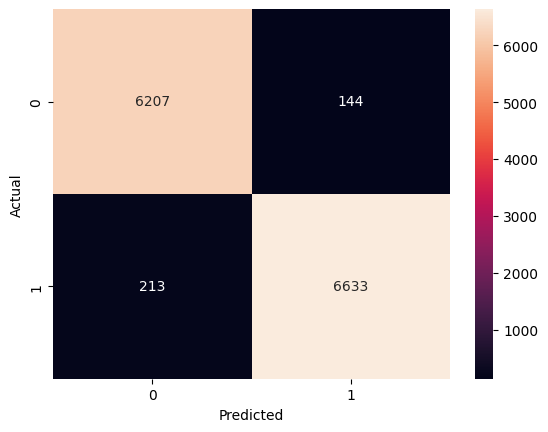

In [6]:
# Evaluate the model
cm = confusion_matrix(y_valid, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')

print(classification_report(y_valid, y_pred_rf))

#### Multinomial Naive Bayes

In [7]:
model_NB = MultinomialNB()
model_NB.fit(X_train, y_train)
y_pred_NB = model_NB.predict(X_valid)

              precision    recall  f1-score   support

           0       0.89      0.99      0.93      6351
           1       0.99      0.88      0.93      6846

    accuracy                           0.93     13197
   macro avg       0.94      0.94      0.93     13197
weighted avg       0.94      0.93      0.93     13197



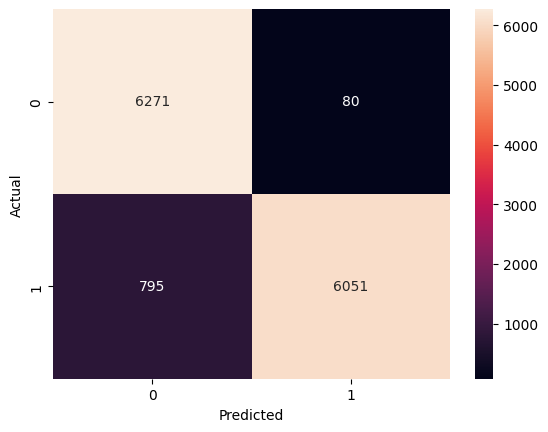

In [8]:
# Evaluate the model
cm = confusion_matrix(y_valid, y_pred_NB)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')

print(classification_report(y_valid, y_pred_NB))